https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f


In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = "~/datasets"
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# pick the MPS
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

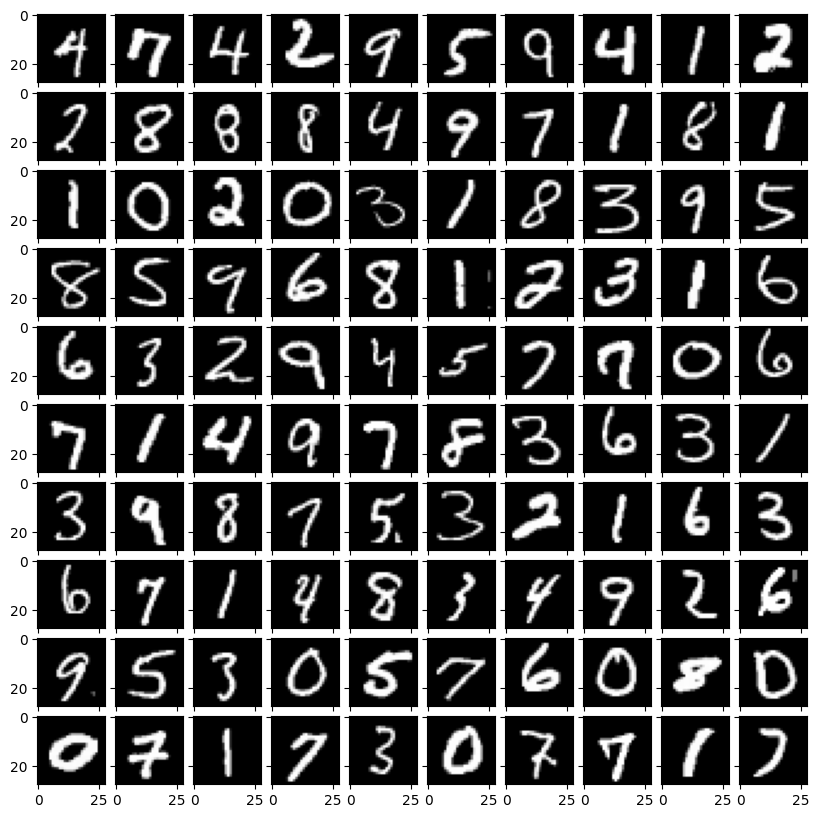

In [3]:
# visualise some of the data
def show_images(images):
    """
    Takes a batch of images from a train_loader, deatches them and converts them to numpy arrays. Then it plots them on a little grid.
    """
    images = images.detach().cpu().numpy()
    images = np.reshape(images, (-1, 28, 28))
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(10, 10), axes_pad=0.1)
    for ax, im in zip(grid, images):
        ax.imshow(im, cmap="gray")
    plt.show()


batch = next(iter(train_loader))[0]
show_images(batch)

In [15]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, latent_dim),
            # tror ej det ska vara ett lager här?
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.Tanh(),
            nn.Linear(latent_dim, input_dim),
            # nn.Tanh(0.2),
            # nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [6]:
def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    DKL = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + DKL

In [40]:
from tqdm import tqdm


def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    losses = []
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, logvar = model(x)
            loss = loss_function(x, x_hat, mean, logvar)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(
            "\tEpoch",
            epoch + 1,
            "\tAverage Loss: ",
            overall_loss / (batch_idx * batch_size),
        )
        losses.append(loss.item())
    return losses


from torch.optim import Adam

model = VAE(hidden_dim=5000, latent_dim=250).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
train(model, optimizer, epochs=10, device=device)

Epoch 1: 100%|██████████| 600/600 [00:09<00:00, 66.40it/s]


	Epoch 1 	Average Loss:  193.06686062056554


Epoch 2: 100%|██████████| 600/600 [00:08<00:00, 67.03it/s]


	Epoch 2 	Average Loss:  173.7062947686248


Epoch 3: 100%|██████████| 600/600 [00:09<00:00, 66.41it/s]


	Epoch 3 	Average Loss:  167.94368669462125


Epoch 4: 100%|██████████| 600/600 [00:08<00:00, 66.91it/s]


	Epoch 4 	Average Loss:  163.8282847062813


Epoch 5: 100%|██████████| 600/600 [00:08<00:00, 67.63it/s]


	Epoch 5 	Average Loss:  161.05475171835872


Epoch 6: 100%|██████████| 600/600 [00:08<00:00, 66.82it/s]


	Epoch 6 	Average Loss:  158.4112095354236


Epoch 7: 100%|██████████| 600/600 [00:08<00:00, 67.16it/s]


	Epoch 7 	Average Loss:  155.73879064391173


Epoch 8: 100%|██████████| 600/600 [00:09<00:00, 66.05it/s]


	Epoch 8 	Average Loss:  153.67702225062604


Epoch 9: 100%|██████████| 600/600 [00:09<00:00, 66.27it/s]


	Epoch 9 	Average Loss:  152.26599580029216


Epoch 10: 100%|██████████| 600/600 [00:09<00:00, 65.64it/s]

	Epoch 10 	Average Loss:  151.16662481088272


[16938.216796875,
 16467.9765625,
 16145.76953125,
 15592.41796875,
 15634.384765625,
 15722.544921875,
 15493.541015625,
 15392.3720703125,
 15132.5048828125,
 15932.31640625]

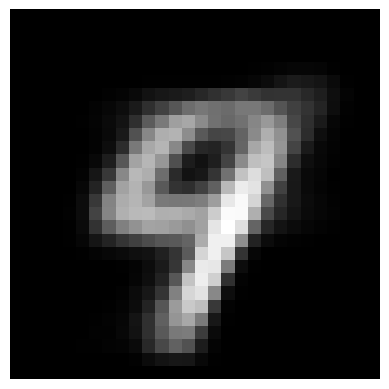

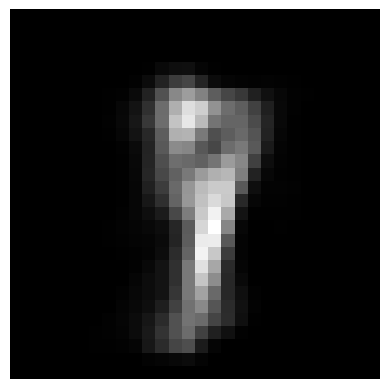

(None, None)

In [36]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array
    plt.imshow(digit, cmap="gray")
    plt.axis("off")
    plt.show()


generate_digit(0.7, 1.0), generate_digit(1.12, 0.0)

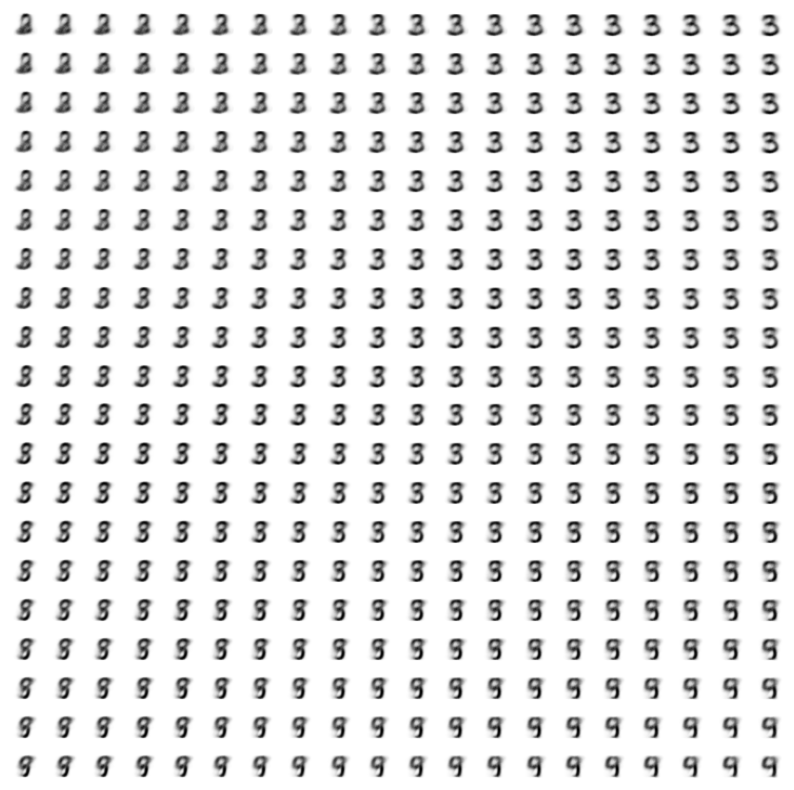

In [42]:
import torch
import matplotlib.pyplot as plt
import numpy as np


def generate_digit(mean, var, show=False):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)  # reshape vector to 2d array

    if show:
        plt.imshow(digit, cmap="gray")
        plt.axis("off")
        plt.show()

    return digit


def plot_digits_grid(start_point, end_point, grid_size=(10, 10)):
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(10, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    start_mean, start_var = start_point
    end_mean, end_var = end_point

    means = np.linspace(start_mean, end_mean, grid_size[0])
    vars = np.linspace(start_var, end_var, grid_size[1])

    for i, mean in enumerate(means):
        for j, var in enumerate(vars):
            digit = generate_digit(mean, var)
            axes[i, j].imshow(digit, cmap="gray_r")
            axes[i, j].axis("off")

    plt.show()


# Example usage
plot_digits_grid((1, 0), (0, 1), grid_size=(20, 20))

In [41]:
# import singular value decompision from scipy
from scipy.linalg import svd

# pick the final layer in the encoder
encoder_latent_space_mean = model.mean_layer.weight.detach().cpu().numpy()
encoder_latent_space_var = model.logvar_layer.weight.detach().cpu().numpy()


# print the shapes
print("Mean shape: ", encoder_latent_space_mean.shape)
print("Var shape: ", encoder_latent_space_var.shape)

# measur the rank of the encoder latent space
print(
    "Rank of the encoder latent space: ",
    np.linalg.matrix_rank(encoder_latent_space_mean),
)

print(
    "Rank of the encoder latent space: ",
    np.linalg.matrix_rank(encoder_latent_space_var),
)

print(
    "Rank of the encoder latent space: ",
    np.linalg.matrix_rank(model.encoder[0].weight.detach().cpu().numpy()),
)

Mean shape:  (2, 250)
Var shape:  (2, 250)
Rank of the encoder latent space:  2
Rank of the encoder latent space:  2
Rank of the encoder latent space:  784


2